# Building and Training a CNN
Today we're going to take the datasets we created yesterday and train a convolutional neural network (CNN) on them. Since this directly depends on the output files from yesterday, take a moment to copy and paste your output files into today's directory. Again, let's take a second to remember our two guiding questions:

- _What_ is in an image (e.g. debris, buildings, etc.)?
- _Where_ are these things located _in 3D space_ ?

Recall that we are posing the first question as a classification problem (e.g. does this image have flooding or not), and we are deploying a CNN to aid in the classification.

As before, this is heavily based off of the following tutorials: https://github.com/LADI-Dataset/ladi-tutorial/blob/master/Tutorials/Pytorch_Data_Load.md, https://github.com/LADI-Dataset/ladi-tutorial/blob/master/Tutorials/Train_Test_Classifier.md

## PyTorch
Yesterday we developed simple machine learning models using sci-kit learn. While the package is good for quick and dirty machine learning models, we are going to need much more powerful tools to take on an image classification task of the kind we're seeing. To that end, we're going to be working with PyTorch, typically considered as the state of the art in deep learning. It was developed primarily by Facebook AI in and released for Python in 2017. There are two main advantages of PyTorch vs. many other Python packages:
- A fairly high level interface for building neural networks
- Parallelization support via GPU
While it is one of the easier ways to build a neural network, there is still a fairly steep learning curve. Thus, today will be all about learning how to implement in PyTorch (and less about what's going on under the hood). 

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
try:
    from torchvision import transforms, utils
except:
    !conda install --yes torchvision --no-channel-priority
    from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
try:
    from torchvision import transforms, utils
except:
    !pip install torchvision
    from torchvision import transforms, utils
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# You want to change these to be your own filenames
csv_file = 'flood_tiny_metadata.csv'
label_csv = 'flood_tiny_label.csv'

## Creating a Dataset from your csv files
The first step to using PyTorch is creating a dataset. All datasets in PyTorch need to be a subclass of torch.utils.data.Dataset, which is the general class that represents a dataset. When creating your dataset, you usually need to overwrite two methods:
- ```__len__```, so that when you call len(dataset) it returns the number of images
- ```__getitem__```, so that when you call dataset[i] it returns the ith item. 
As usual, we're also going to define ```__init__``` to take in the arguments we care about.

We also need to decide what we want a sample of our dataset to look like. Ours is going to look like a dictionary as follows: ```{'image': image, 'image_name': img_name, 'damage:flood/water': label, uuid': uuid, 'timestamp': timestamp, 'gps_lat': gps_lat, 'gps_lon': gps_lon, 'gps_alt': gps_alt, 'orig_file_size': file_size, 'orig_width': width, 'orig_height': height}```. Of course, there's no requirement that it be a dictionary, though it should somehow incorporate the input and output (in our case, the image and the label). 

In [2]:
torch.cuda.is_available()

True

In [3]:
# convenient function for showing the images
def show_image(image):
    plt.imshow(image)
    # pause a bit so that plots are updated
    plt.pause(0.01)

In [4]:
def convert_url_to_local_path(url):
    '''
    gets the location of the image in the shared directory so we don't have to redownload
    '''
    return '/home/jovyan/course/ladi/'+'/'.join(url.split('/')[3:])

class FloodTinyDataset(Dataset):

    def __init__(self, csv_file, label_csv, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with metadata.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.flood_tiny_metadata = pd.read_csv(csv_file)
        # get the path in the shared directory
        self.flood_tiny_metadata['local_path'] = self.flood_tiny_metadata['url'].apply(convert_url_to_local_path)
        self.flood_tiny_label = pd.read_csv(label_csv)
        self.flood_tiny_data = pd.merge(self.flood_tiny_metadata, 
                                        self.flood_tiny_label,
                                       on="s3_path")
        self.transform = transform
        
    def __len__(self):
        return len(self.flood_tiny_metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ## Load images from shared directory. There is no need to download images to local machine. ##
        local_path = self.flood_tiny_metadata.iloc[idx]['local_path']
        url = self.flood_tiny_metadata.iloc[idx]['url']
        try:
            image = Image.fromarray(io.imread(local_path))
            img_name = local_path
        except:
            image = Image.fromarray(io.imread(url))
            img_name = url
        uuid = self.flood_tiny_data.iloc[idx, 1]
        timestamp = self.flood_tiny_data.iloc[idx, 2]
        gps_lat = self.flood_tiny_data.iloc[idx, 3]
        gps_lon = self.flood_tiny_data.iloc[idx, 4]
        gps_alt = self.flood_tiny_data.iloc[idx, 5]
        file_size = self.flood_tiny_data.iloc[idx, 6]
        width = self.flood_tiny_data.iloc[idx, 7]
        height = self.flood_tiny_data.iloc[idx, 8]
        label = self.flood_tiny_data.iloc[idx, -1]
        
        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'image_name': img_name, 'damage:flood/water': label, 'uuid': uuid, 'timestamp': timestamp, 'gps_lat': gps_lat, 'gps_lon': gps_lon, 'gps_alt': gps_alt, 'orig_file_size': file_size, 'orig_width': width, 'orig_height': height}

        return sample

0 True /home/jovyan/course/ladi/Images/FEMA_CAP/1013/20195/DSC_0529_4b2d9291-c0d8-4e26-aeed-5ff03f83bd6a.jpg 405c090c177e5f22cabc7ff4124dbbdd66bd3413 2015-10-08 12:35:10 33.6119183333333 -79.83629499999998 331.0


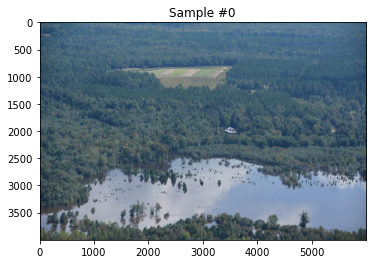

1 False /home/jovyan/course/ladi/Images/FEMA_CAP/9074/613596/DSC_2010_646d76d1-d5cf-44a0-9031-9cf209cf12c5.jpg 24ae646224a2937d186d10b999b7ca0155a116c1 2017-09-08 10:20:57 18.334536666666697 -64.939215 329.0


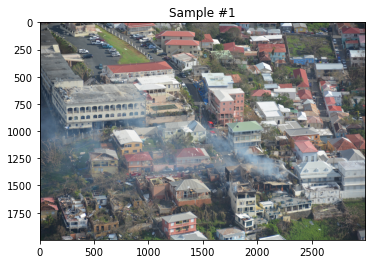

2 True /home/jovyan/course/ladi/Images/FEMA_CAP/1014/200876/Ten_mile_3231ddc2-708f-4590-8c1c-b237815b9cf4.jpg f313a3a8fa9bc164cfdf7fb445bea6a03249cabd 2016-05-25 14:59:27 39.601905555555604 -123.58154166666701 1215.0


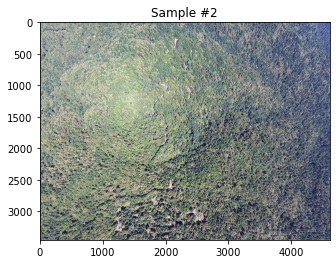

3 False /home/jovyan/course/ladi/Images/FEMA_CAP/9074/613833/DSC_1305_c7860632-976e-48b1-a97d-346c67bab221.jpg d395f0c99ccfb48c336a115191a231866013a48e 2017-09-18 10:44:55 24.6405066666667 -81.460105 343.0


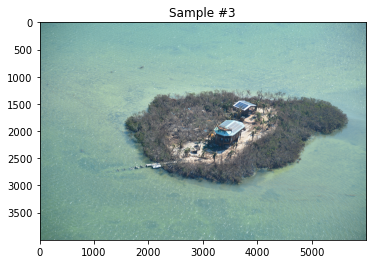

4 False /home/jovyan/course/ladi/Images/FEMA_CAP/1013/20187/DSC_0143_64c0bc5c-a7f7-4af6-9d55-04aef8d4b410.jpg 0ddfc462b81f914ca91c1ba7cecd345e9cec7a66 2015-10-08 16:16:54 33.50362 -79.1211533333333 402.0


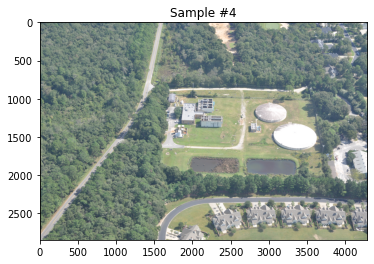

5 False /home/jovyan/course/ladi/Images/FEMA_CAP/1013/20187/DSC_0153_69ef4520-2339-4750-9111-f2b2907ed4f3.jpg e15550b5f7279cd14fb395bcbab39e44f9dfbc3a 2015-10-08 16:25:53 33.3920933333333 -79.31333000000002 964.0


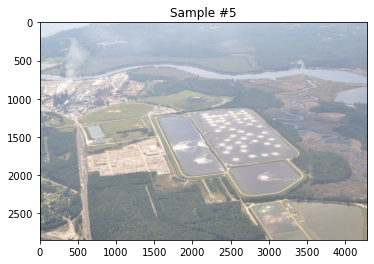

In [5]:
# Let's do a quick sanity check
flood_tiny_dataset = FloodTinyDataset(csv_file = csv_file, label_csv = label_csv)

fig = plt.figure()

for i in range(len(flood_tiny_dataset)):
    sample = flood_tiny_dataset[i]

    print(i, 
          sample['damage:flood/water'], 
          sample['image_name'], 
          sample['uuid'], 
          sample['timestamp'], 
          sample['gps_lat'], 
          sample['gps_lon'], 
          sample['gps_alt'])

    plt.tight_layout()
    plt.title('Sample #{}'.format(i))
    show_image(sample['image'])

    if i == 5:
        plt.show()
        break

## Transformations
There are now two things to take care of:
- Neural networks usually expect all images to be of the same size, but sometimes datasets are not all of the same size. The LADI dataset includes image of different sizes. 
- Like we saw in our thought exercise last class, there is a huge amount of variability. Because of this, the top performing CNN's usually train on hundreds of thousands of images, much more than what we have! We're going to have to somehow increase the number of images available to us. 

One solution is to augment the dataset by *transforming* it. Most transformations are actually fairly straightforward.

- ```Resize```: to resize the input PIL Image to the given size.
- ```RandomCrop```: to crop from image randomly. This is data augmentation.
- ```RandomRotation```: to rotate the image by angle.
- ```RandomHorizontalFlip```: to horizontally flip the given PIL Image randomly with a given probability.
- ```ToTensor```: to convert the numpy images to torch images (we need to swap axes).

These functions each have their own set of arguments, which can be referenced here(https://pytorch.org/docs/stable/torchvision/transforms.html)

Now let's try to apply these transforms, first individually and then all at once. The key to effective transforms is to have "enough" transformation that the input image is visually distinct from the output image, but not so much that the output image is no longer representative of the dataset. 

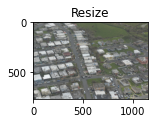

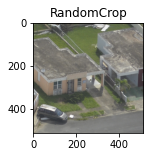

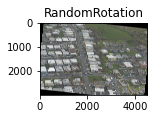

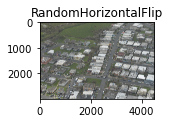

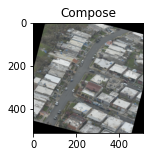

In [6]:
scale = transforms.Resize(768)
crop = transforms.RandomCrop(512)
rotate = transforms.RandomRotation(20)
flip_demo = transforms.RandomHorizontalFlip(1) # flip with 100% chance just to demo
flip = transforms.RandomHorizontalFlip(p=0.5)
composed = transforms.Compose([scale,
                               crop,
                               rotate,
                               flip_demo])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = flood_tiny_dataset[198]
for i, tsfrm in enumerate([scale, crop, rotate, flip_demo, composed]):
    transformed_image = tsfrm(sample['image'])

    ax = plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_image(transformed_image)

plt.show()

## DataLoader
Compared to simple ```for``` loop to iterate over data, ```torch.utils.data.DataLoader``` is an iterator which provides more features:

- Batching the data.
- Shuffling the data.
- Load the data in parallel using multiprocessing workers.

In the previous section, three transforms are performed on a sample. In this section, users can learn to use ```DataLoader``` to transform all images in the dataset.

First, a new dataset with transform needs to be defined.

In [7]:
transformed_dataset = FloodTinyDataset(csv_file = csv_file, 
                                       label_csv = label_csv, 
                                       transform = transforms.Compose([scale, 
                                                                       crop, 
                                                                       rotate, 
                                                                       flip, 
                                                                       transforms.ToTensor()]
                                                                     )
                                      )

In [8]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

In [9]:
# Helper function to show a batch
def show_images_batch(sample_batched):
    images_batch = sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title('Batch from dataloader')

0 torch.Size([4, 3, 512, 512])
1 torch.Size([4, 3, 512, 512])
2 torch.Size([4, 3, 512, 512])
3 torch.Size([4, 3, 512, 512])


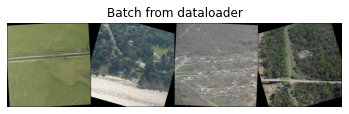

In [10]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].cuda().size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_images_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

### Exercise
Using the csv files you created yesterday, create your own DataLoader using transforms that you think would be interesting or helpful. Here's a full list of transforms: https://pytorch.org/docs/stable/torchvision/transforms.html

As a group, answer the following questions
- Are the image labels accurate? That is to say, if it is labeled as having a flood, does it actually have a flood?
- Do the transforms add enough variety to the dataset? Do they still look representative of the dataset?
- Do the transforms distort from the labels? For example, if you use a random crop, is the thing that is being labeled still present in the image?

## Training a neural network
We are now ready to train a CNN! We are going to start with a familiar step: we're going to split the dataset into a training and testing set.

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

batch_size = 64
test_split_ratio = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(transformed_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split_ratio * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,
                                                sampler=test_sampler)

Now we are going to define our CNN architecture. It is going to be a combination of convolutional layers and fully connected layers. Here's the documentation of each of the layers: https://pytorch.org/docs/stable/nn.html \*. 

\* At this point, you might be wondering how I decided on this particular architecture. Why do we have 2 convolutional layers and not 3 (or 1 or 5)? The reality is that deciding on a neural network architecture is more of an art than a science. If you were to look up on the web for popular architectures, you would find thousands of architectures for all sorts of purposes. There are some general features that would make it more or less attractive for particular tasks, but really it's something you get a feel for rather than an exact science. 

In [12]:
import torch.nn as nn
import torch.nn.functional as F
try:
    from cnn_finetune import make_model
except:
    !pip install cnn-finetune
    from cnn_finetune import make_model

net = make_model('resnet18', num_classes=2, pretrained=True).cuda()


     |████████████████████████████████| 58 kB 3.1 MB/s eta 0:00:011
  Created wheel for cnn-finetune: filename=cnn_finetune-0.6.0-py3-none-any.whl size=11432 sha256=7bb873736b7591d51c383ec61e7eebbd7fe9f52976413fdb30fc2e7cbc96f347
  Stored in directory: /home/jovyan/.cache/pip/wheels/f4/ab/20/954e052b50cf464bb0cc1e4917f2a24f0fbc5ac51f60410bb7
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=639739ce325fc8ed5534fa0b3c5dcb9648c3d98d5ed1c6776d77d98c0d19567d
  Stored in directory: /home/jovyan/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built cnn-finetune pretrainedmodels


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jovyan/.cache/torch/checkpoints/resnet18-5c106cde.pth


We're now going to define the loss function and the optimizer. You can think of the loss function as the amount of error you want to minimize, while the optimizer is the specific tool you're going to use to minimize that loss. 

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Finally, we're going to do the actual training.

In [14]:
torch.backends.cudnn.benchmark = True # flag for some GPU optimizations
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['image'].cuda()
        labels = data['damage:flood/water'].cuda()
        # casting int to long for loss calculation#
        labels = labels.long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 10 == 0:    # print every 10 mini-batches
            print(f'[epoch {epoch+1}, batch {i +1} ] average loss: {running_loss/10}')
            running_loss = 0.0
    # save the model
    PATH = f'epoch_checkpoints/flood_checkpoint_epoch{epoch}.pth'
    torch.save(net.state_dict(), PATH)
print('Finished Training')



NameError: name 'batch' is not defined

### Exercise
Using your own dataset, set up your neural network so that it is ready to train. Leave it training overnight (it will take a *long* time for it to run). Make sure there are no obvious errors in your code. 

## Performance evaluation

Now that we have a fully trained CNN, we would like to see how well it performs on unseen data. Let's first take a sample of testing images and displaying their ground truth.

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
single_iter = dataiter.next()
images = single_iter['image']
labels = single_iter['damage:flood/water']

In [ ]:
# print images
imshow(utils.make_grid(images))
print('GroundTruth: \n', ' '.join('%5s' % labels[j].cpu() for j in range(16)))

Then, we can load the saved model and make some predictions on the images above.

In [ ]:
net.load_state_dict(torch.load(PATH))

outputs = net(images.cuda())
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j].cpu()
                              for j in range(16)))

Now, we can look at how the trained network performs on the whole testing set.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images = data['image'].cuda()
        labels = data['damage:flood/water'].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

In addition, we can look at the performance of the model on each class of ```damage:flood/water: True``` and ```damage:flood/water: False```.

In [ ]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_loader:
        images = data['image'].cuda()
        labels = data['damage:flood/water'].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(16):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

## Exercise
Display the performance of your neural network. Is the overall accuracy as good as you expected? What about the class accuracy? Does it perform better on one class than another? 

# Bias and ethics in machine learning
While we wait for our neural networks to train, let's take a step back and think about what it is that we're trying to do. AI actually provides a very timely and rich context in which we can discuss questions of ethics, equity and justice. 

Background material:
Designing AI with Justice (this will be our main piece), Costanza-Chock: https://www.publicbooks.org/designing-ai-with-justice/

Can we make artificial intelligence ethical?, Schwarzman: https://www.washingtonpost.com/opinions/2019/01/23/can-we-make-artificial-intelligence-ethical/

The Apple Card Didn't 'See' Gender—and That's the Problem, Knight: https://www.wired.com/story/the-apple-card-didnt-see-genderand-thats-the-problem/

Color film was built for white people. Here's what it did to dark skin, Vox: https://www.youtube.com/watch?v=d16LNHIEJzs

## Science as a social process
Something that might seem a bit strange and perhaps even a bit uncomfortable is the idea of science as a social construction. There's a couple of things to note here:
- **Not everyone subscribes to this view of science.** There are a lot of more classical schools of thought that hold science as a sort of bastion of everything that is objective.
- **Just because science is socially constructed does not mean that it does not exist.** Can you think of something else that exists even though it is a social construct?

How are some ways that the social construction of science can present itself?
- Who funds research and why? Under what constraints?
- For whom is the product of research directed to?
- Who creates the products?
- Who holds (or has historically held) a position of position of power in society?
- To what end is knowledge being generated?

**How are some ways that human bias can seep into machine learning algorithms?**

**How does this apply to the aerial imagery we are working with?**

**What do we do about it? Should we just give up on creating these models?**

### Exercise
Take a critical look at both the LADI dataset and the techniques that we are applying to it. As a group, answer the following questions:
- How might human bias be present in the LADI dataset? Think about both the imagery and the labels, as well as how these data were gathered?
- How might human bias be present in the machine learning techniques we apply to these imagery?
- If we were to build a classifier that can predict your choice of target, how might the problems outlined above yield issues in equity?
- To what extent can these issues be resolved with the dataset and machine learning techniques as they exist?
- If you could completely redo the process of arriving at the LADI dataset and doing your analysis, what would you do differently?

Be prepared to present on these at the end of the discussion period.